# LSN - simulation test code

In [0]:
# Package imports
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import time
import math
from datetime import datetime

In [0]:
# Main slim library
slim = tf.contrib.slim

class siamese_net(object):
  
    def __init__(self, net_arch):
              
      self.input_L = tf.placeholder(tf.float32, [None, net_arch['input_shape']],name='baseline')
      self.input_R = tf.placeholder(tf.float32, [None, net_arch['input_shape']],name='follow_up')
      self.aux_gen = tf.placeholder(tf.float32, [None,1],name='apoe')  #apoe4 status
      self.aux_clinical = tf.placeholder(tf.float32, [None,net_arch['aux_clinical_shape']],name='clinical_attr') #demo+clinical scores
      self.labels = tf.placeholder(tf.float32, [None,2],name='trajectory')         
      self.use_aux = True #use aux branch for non-imaging variables
      self.is_training = True  #toggles dropout in slim
      self.dropout = 1

      with tf.variable_scope("siamese") as scope:
          self.branch_L = self.mlpnet_slim(self.input_L)
          scope.reuse_variables()
          self.branch_R = self.mlpnet_slim(self.input_R)
          
      # Create metrics      
      self.distance = tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(self.branch_L,self.branch_R),2),1,keepdims=True))
      self.preds = self.get_predictions()
      self.loss = self.get_loss()
      self.accuracy = self.get_accuracy()

    # Individual branch    
    def mlpnet_slim(self, X):
      with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.relu,
                          weights_regularizer=slim.l2_regularizer(net_arch['reg'])):
        
        # within the scope layer is made linear by setting activation_fn=None.

        # Creates a fully connected layer from the inputs 
        net = slim.fully_connected(X, net_arch['l1'], normalizer_fn=slim.batch_norm, scope='fc1')
        #end_points['fc1'] = net                
        net = slim.dropout(net, self.dropout, is_training=self.is_training)

        # Adds another fully connected layer 
        net = slim.fully_connected(net, net_arch['l2'], normalizer_fn=slim.batch_norm, scope='fc2')                                                
        #end_points['fc2'] = net                
        net = slim.dropout(net, self.dropout, is_training=self.is_training)

        # Adds another fully connected layer 
        net = slim.fully_connected(net, net_arch['l3'], normalizer_fn=slim.batch_norm, scope='fc3')                                                
        #end_points['fc3'] = net 
        net = slim.dropout(net, self.dropout, is_training=self.is_training)

        # Adds another fully connected layer 
        net = slim.fully_connected(net, net_arch['l4'], normalizer_fn=slim.batch_norm, scope='fc4')                                                
        #end_points['fc4'] = net 
        net = slim.dropout(net, self.dropout, is_training=self.is_training)

        # MR output
        MR_predictions = slim.fully_connected(net, net_arch['mr_output'], 
                                              normalizer_fn=slim.batch_norm, scope='MR_prediction')               
        #end_points['out'] = MR_predictions            
        return MR_predictions #Later also return end_points 
    
    # Auxilary branch for demographics, genetics, and clinical attributes
    def auxnet(self):
      distance_vec  = tf.concat([self.branch_L,self.branch_R],1,name='MR_embed_concat')
      distance_vec_mod = tf.multiply(distance_vec,self.aux_gen)
      distance_vec_mod_aux = tf.concat([distance_vec_mod,self.aux_clinical],1)
      
      with tf.name_scope('aux_layers'):
        aux_predictions = slim.fully_connected(distance_vec_mod_aux, net_arch['aux_output'],
                                               activation_fn=tf.nn.relu, 
                                               weights_regularizer=slim.l2_regularizer(net_arch['reg']),
                                               normalizer_fn=slim.batch_norm) 
        #aux_predictions = slim.dropout(net, self.dropout, is_training=is_training)
        return aux_predictions
        
    def get_predictions(self):
      if self.use_aux:
        embed_vec = self.auxnet()
      else:
        embed_vec = tf.concat([self.branch_L,self.branch_R],1,name='MR_embed_concat')
        
      penult_predict = slim.fully_connected(embed_vec, net_arch['output'], activation_fn=tf.nn.softmax, 
                                           normalizer_fn=slim.batch_norm, scope='aux_prediction')
      return penult_predict
    
    #-------------- net with basic/raw TF code (without slim) --------------#
    #-------------- not used when slim is used -----------------------------#
    def mlpnet(self, X):
      l1 = self.mlp(X,layer_config['input_shape'],layer_config['l1'],name='l1')
      l1 = tf.nn.dropout(l1,self.dropout)
      l2 = self.mlp(l1,layer_config['l1'],layer_config['l2'],name='l2')
      l2 = tf.nn.dropout(l2,self.dropout_f)
      l3 = self.mlp(l2,layer_config['l2'],layer_config['l3'],name='l3')
      l3 = tf.nn.dropout(l3,self.dropout)
      l4 = self.mlp(l3,layer_config['l3'],layer_config['l4'],name='l4')
      l4 = tf.nn.dropout(l4,self.dropout)
      output = self.mlp(l4,layer_config['l4'],layer_config['output'],name='output')
      return output
      
    def mlp(self, input_,input_dim,output_dim,name="mlp"):
      with tf.variable_scope(name):
        w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.random_normal_initializer(mean = 0.001,stddev=0.02))            
        b = tf.get_variable('b',[output_dim],tf.float32,tf.constant_initializer(0.1))
        return tf.nn.relu(tf.matmul(input_,w)+b)   
    #-----------------------------------------------------------------------#
   
    # Set methods class variables
    def set_dropout(self, dropout):
      self.dropout = dropout
      
    def set_aux(self, use_aux):
      self.use_aux = use_aux
      
    def set_train_mode(self,is_training):  
      self.is_training = is_training
      
    # Get methods for loss and acc  
    def get_loss(self):            
      return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels,logits=self.preds)) 

    def get_accuracy(self):
      correct_preds = tf.equal(tf.argmax(self.labels,1), tf.argmax(self.preds,1))
      return tf.reduce_mean(tf.cast(correct_preds, tf.float32)) 
       
    
# Other helper functions
def next_batch(s,e,mr_inputs,aux_inputs,labels):
    input1 = mr_inputs[s:e,0]
    input2 = mr_inputs[s:e,1]        
    input3 = aux_inputs[s:e,:]
    y = np.reshape(labels[s:e],(len(range(s,e)),2))    
    return input1,input2,input3,y
  
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    left_digits = []
    right_digits = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[x[z1], x[z2]]]            
            left_digits.append(d)
            right_digits.append(d)            
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            left_digits.append(d)
            right_digits.append(dn)
    return np.array(pairs), np.array(labels), np.array(left_digits), np.array(right_digits)


In [10]:
lr = 0.001
n_epochs = 10
batch_size = 128
dropout = 0.5
net_arch = {'input_shape':100,'l1':100,'l2':100,'l3':100,'l4':100,'mr_output':10,
            'aux_clinical_shape':4,'aux_output':5,'output':2,'reg':0.01}
sampx = 10000
X_MR_train = np.random.rand(sampx,2,100)
X_aux_train = np.random.rand(sampx,5)
y_train = np.vstack((np.random.rand(sampx) > 0.5, np.random.rand(sampx) <= 0.5)).T

X_MR_test = np.random.rand(int(sampx/10),2,100)
X_aux_test = np.random.rand(int(sampx/10),5)
y_test = np.vstack((np.random.rand(int(sampx/10)) > 0.5, np.random.rand(int(sampx/10)) <= 0.5)).T

total_batch = int(y_train.shape[0]/batch_size)

print('shapes of X_MR_train:{}, X_aux_train:{}, y_train:{}, \n\t X_MR_test:{}, X_aux_test:{}, y_test:{}'.format(X_MR_train.shape,X_aux_train.shape,y_train.shape,X_MR_test.shape,X_aux_train.shape,y_test.shape)) 

shapes of X_MR_train:(10000, 2, 100), X_aux_train:(10000, 5), y_train:(10000, 2), 
	 X_MR_test:(1000, 2, 100), X_aux_test:(10000, 5), y_test:(1000, 2)


In [0]:
# Train and test defs
def train_lsn(sess, lsn, data, n_epochs, batch_size, dropout):
  # Training cycle
  for epoch in range(n_epochs):
      avg_loss = 0.
      avg_acc = 0.

      X_MR_train = data['X_MR_train']
      X_aux_train = data['X_aux_train']
      y_train = data['y_train']
      
      start_time = time.time()

      # Loop over all batches
      for i in range(total_batch):
          s  = i * batch_size
          e = (i+1) *batch_size

          # Fit training using batch data
          MR_L_batch,MR_R_batch,aux_batch,y_batch = next_batch(s,e,X_MR_train,X_aux_train,y_train)

          #print(input1.shape, input2.shape, y.shape)                

          # Train pass
          lsn.set_dropout(dropout)
          _,distance,preds,loss_value,acc_value=sess.run([optimizer,lsn.distance,lsn.preds,lsn.loss,lsn.accuracy], 
                                        feed_dict={lsn.input_L:MR_L_batch,
                                                   lsn.input_R:MR_R_batch,
                                                   lsn.aux_gen:aux_batch[:,0:1],
                                                   lsn.aux_clinical:aux_batch[:,1:],
                                                   lsn.labels:y_batch})                

          #tr_acc = compute_accuracy(predict,y)
          #print(tr_acc)

          avg_loss += loss_value
          avg_acc +=acc_value*100

      # Compute preds and metrics for entire train data
      train_feature_1 = lsn.branch_L.eval(feed_dict={lsn.input_L:X_MR_train[:,0,:]})
      train_feature_2 = lsn.branch_R.eval(feed_dict={lsn.input_R:X_MR_train[:,1,:]})    
      train_preds= lsn.preds.eval(feed_dict={lsn.input_L:X_MR_train[:,0,:],lsn.input_R:X_MR_train[:,1,:],
                                      lsn.aux_gen:X_aux_train[:,0:1],lsn.aux_clinical:X_aux_train[:,1:]})
      
      train_metrics = {'train_feature_1':train_feature_1,'train_feature_2':train_feature_2,'train_preds':train_preds}
      duration = time.time() - start_time
      print('epoch %d  time: %.2f loss %0.4f acc %0.2f' %(epoch,duration,avg_loss/(total_batch),avg_acc/total_batch))      
      
  return lsn, train_metrics

def test_lsn(sess,lsn,data):
  print('Testing model')    
  lsn.set_dropout(1)
  lsn.set_train_mode(False) 
  X_MR_test = data['X_MR_test']
  X_aux_test = data['X_aux_test']
  y_test = data['y_test']
  #print(lsn.dropout)
  
  test_feature_1 = lsn.branch_L.eval(feed_dict={lsn.input_L:X_MR_test[:,0,:]})
  test_feature_2 = lsn.branch_R.eval(feed_dict={lsn.input_R:X_MR_test[:,1,:]})

  test_preds = lsn.preds.eval(feed_dict={lsn.input_L:X_MR_test[:,0,:],lsn.input_R:X_MR_test[:,1,:],
                                      lsn.aux_gen:X_aux_test[:,0:1],lsn.aux_clinical:X_aux_test[:,1:]})
  test_acc = lsn.accuracy.eval(feed_dict={lsn.input_L:X_MR_test[:,0,:],lsn.input_R:X_MR_test[:,1,:],
                                       lsn.aux_gen:X_aux_test[:,0:1],lsn.aux_clinical:X_aux_test[:,1:],
                                       lsn.labels:y_test})

  test_metrics = {'test_feature_1':test_feature_1,'test_feature_2':test_feature_2,'test_preds':test_preds}
  print('Accuract test set %0.2f' % (100 * test_acc))
  return lsn, test_metrics


In [19]:
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    lsn = siamese_net(net_arch)
    optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(lsn.loss)
    #sess.run(init)
    tf.global_variables_initializer().run()

    cur_time = datetime.time(datetime.now())
    print('Start training time: {}'.format(cur_time))
    
    # Train model
    data = {'X_MR_train':X_MR_train,'X_aux_train':X_aux_train,'y_train':y_train}
    lsn, train_metrics = train_lsn(sess, lsn, data, n_epochs, batch_size, dropout)
       
    cur_time = datetime.time(datetime.now())
    print('End training time: {}'.format(cur_time))      
    
    # Test model      
    data = {'X_MR_test':X_MR_test,'X_aux_test':X_aux_test,'y_test':y_test}
    _,test_metrics = test_lsn(sess,lsn,data)

Start training time: 21:57:56.203134
epoch 0  time: 0.81 loss 0.7133 acc 48.76
epoch 1  time: 0.61 loss 0.6716 acc 56.25
epoch 2  time: 0.62 loss 0.6503 acc 58.93
epoch 3  time: 0.62 loss 0.6321 acc 60.75
epoch 4  time: 0.62 loss 0.6187 acc 62.43
epoch 5  time: 0.61 loss 0.6100 acc 63.57
epoch 6  time: 0.61 loss 0.6006 acc 64.90
epoch 7  time: 0.62 loss 0.5956 acc 65.72
epoch 8  time: 0.62 loss 0.5901 acc 66.60
epoch 9  time: 0.61 loss 0.5844 acc 67.09
End training time: 21:58:02.558718
Testing model
Accuract test set 47.80


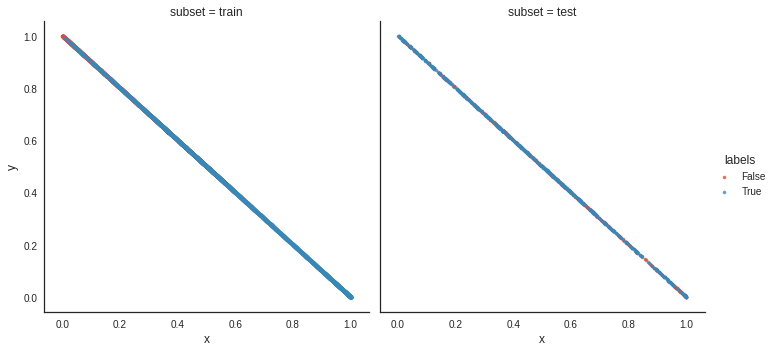

In [46]:
#Plot embeddings
train_features = train_metrics['train_preds']
test_features = test_metrics['test_preds']

plt.style.use('seaborn-white')

train_df = pd.DataFrame(columns=['x','y','labels','subset'])
test_df = pd.DataFrame(columns=['x','y','labels','subset'])
train_df['x'] = train_features[:,0] 
train_df['y'] = train_features[:,1] 
train_df['labels'] = y_train
train_df['subset'] = np.tile('train',len(y_train))
test_df['x'] = test_features[:,0] 
test_df['y'] = test_features[:,1] 
test_df['labels'] = y_test
test_df['subset'] = np.tile('test',len(y_test))
plot_df = train_df.append(test_df)
sns.lmplot(x='x',y='y',hue='labels',col='subset',fit_reg=False, markers='.',data=plot_df);





